# Análise e classificação de produtos do marketplace.
### Classificação de produtos pela categoria e distinção de produtos únicos.

Neste notebook exploramos diferentes estratégias de ML/DL para classificar produtos em suas categorias, analisar o desempenho dos classificadores sobre base com milhares de róturos e dinstinguí-los entre suas correspondentes variantes.

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, ward, complete
#from sklearn.cluster import AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances

from gensim.models.fasttext import FastText

# Módulos locais

from utils.text_clean import clean_text
from utils.word2vec import Word2VecModel
from utils.doc2vec import Doc2VecModel

from utils.clfs import Clfs

from utils.plots import plot_acc_classes, plot_dists
from utils.evaluation import cluster_accuracy
from utils.np2json2np import EncodeFromNumpy

In [2]:
headers = ["p_id", "p_title", "vendor_id", "cluster_id", "cluster_title", "cat_id", "cat_title"]
df = pd.read_csv('datasets/pricerunner_aggregate.csv', header=0, names = headers)
#df = df[df.cat_id == 2612]
df.head()

,p_id,p_title,vendor_id,cluster_id,cluster_title,cat_id,cat_title
0,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,6,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,6,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


# Construção de atributos (Features)

In [3]:
df = df[ (df.p_title.notna()) & (df.p_title.notnull()) ]

In [4]:
# Atribuindo a cada produto da base um inteiro com a quantidade de nomes
# diferentes estão associados ao seu ID (incluindo ele).
counts = df.cluster_id.value_counts()
freqs = [ counts[cid] for cid in df.cluster_id ]
df["freqs"] = freqs

In [5]:
feat_tokens = clean_text(df.p_title.values)

In [6]:
w2v_params = {
    "sentences": feat_tokens,
    "vector_size": 100,
    "sg": 0,
    "window": 6,
    "epochs": 10,
    "workers": 10
}

w2v = Word2VecModel(feat_tokens, params=w2v_params)

d2v_params = {
    "documents":  feat_tokens,
    "vector_size": 100,
    "dm": 0,
    "window": 6,
    "epochs": 10,
    "dbow_words": 1,
    "workers": 10
}

d2v = Doc2VecModel(feat_tokens, params=d2v_params)

In [7]:
representacoes = {}
representacoes["word2vec"] = w2v.transform(feat_tokens)
representacoes["doc2vec"] = d2v.transform(len(feat_tokens))

# Classificação de produtos por categoria.

Verificando o desempenho dos classificadores por categoria.

In [8]:
r = np.random
seed = r.randint(0, 2147483647 * 2)

classifiers = {
    "RandomForestClassifier": RandomForestClassifier(n_jobs=10, random_state=seed),
    "LogisticRegression": LogisticRegression(max_iter=400, multi_class='multinomial', n_jobs=10, random_state=seed),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=seed),
    "KNeighborsClassifier": KNeighborsClassifier(n_jobs=10),
    "SVC": SVC(random_state=seed)
}

"""
classifiers = {
    "RandomForestClassifier": RandomForestClassifier(n_jobs=10, random_state=seed),
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=10, random_state=seed),
    "KNeighborsClassifier": KNeighborsClassifier(n_jobs=10)
}
"""

"""
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=10, random_state=seed),
    "KNeighborsClassifier": KNeighborsClassifier(n_jobs=10)
}
"""



'\nclassifiers = {\n    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class=\'multinomial\', n_jobs=10, random_state=seed),\n    "KNeighborsClassifier": KNeighborsClassifier(n_jobs=10)\n}\n'

### Avaliando diferentes classificadores para classificação dos produtos em suas categorias.

In [ ]:
pipeline = Clfs()

results = []
scores_rep = {}
for rep in representacoes:
    scores_clfs = pipeline.fast_avaliation(classifiers, representacoes[rep], df.cat_id)
    for clf in scores_clfs:
        results.append([rep, clf, scores_clfs[clf]["mean_f1"], scores_clfs[clf]["std_f1"]])

cat_results = pd.DataFrame(results, columns=["Rep", "Clf", "MeanF1", "StdF1"])
timestamp = time.strftime("%Y-%m-%d - %H:%M:%S")
cat_results.to_csv(f'tables/f1_rep_{timestamp}.csv', index=False)
cat_results.head(10)

# Verificação dos classificadores para o problema PU.

### Análise do desempenho dos classificadores conforme mais produtos são adicionados a classificação.

In [ ]:
pipeline = Clfs()

r = np.random
seed = r.randint(0, 2147483647 * 2)

# Verificando a taxa de acerto pela quantidade de classes.
#n_folds = 5
limit = 30
results = {}
for n_class in range(3, 11):
    ids = list(set(df[(df.freqs >= n_class) & (df.cat_id == 2622)].cluster_id))
    results[n_class] = {}
    for i in range(3, limit):
        results[n_class][i] = {}
        # Escolhendo um sample de produtos aleatório da base.
        clusters_ids = np.random.choice(ids, i)
        set_sample = df.cluster_id.isin(clusters_ids)
        # Para cada representação.
        for rep in representacoes:
            target = df[set_sample]["cluster_id"].values
            features = representacoes[rep][set_sample]
            results[n_class][i][rep] = pipeline.fast_avaliation(classifiers, features, target, n_folds=n_class)

In [ ]:
plot_acc_classes(results, limit)

# Agrupamento de PUs por categoria

### Para cada categoria inicial da base de dados vamos agrupar os produtos únicos com a técnica de clustering aglomerativo. Utilizamos essa técnica isoladamente por categoria para que essa escale com maior facilidade conforme aumenta o volume dos dados.

In [24]:
cat_ids = set(df.cat_id)

dists = {}
for cat_id in cat_ids:
    print(cat_id)
    indexes = df.cat_id.isin([cat_id])
    feats = representacoes["word2vec"][indexes]
    dist = pairwise_distances(feats, metric="manhattan", n_jobs=10)
    np.fill_diagonal(dist,0)
    dists[cat_id] = squareform(dist)

2612
2614
2615
2617
2618
2619
2620
2621
2622
2623


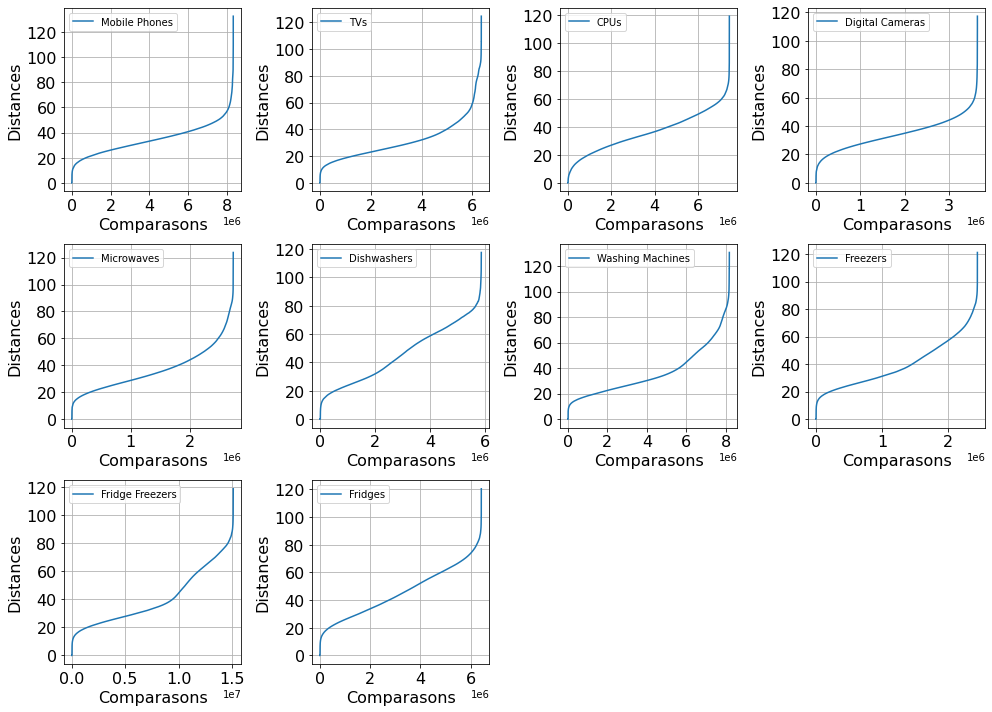

In [12]:
plot_dists(dists, df)

In [29]:
dict_labels = {}
for cat_id in dists:
    dict_labels[cat_id] = cut_tree(ward(dists[cat_id]), height=1)

In [30]:
from sklearn import preprocessing
for cat_id in dict_labels:
    le = preprocessing.LabelEncoder()
    le.fit(df[df.cat_id == cat_id].cluster_id.values)
    targs = le.transform(df[df.cat_id == cat_id].cluster_id.values)
    acc = cluster_accuracy(targs, dict_labels[cat_id])
    print("Cat.: ", cat_id, "Acurácia: ", acc)

Cat.:  2612 Acurácia:  1.0
Cat.:  2614 Acurácia:  0.5
Cat.:  2615 Acurácia:  1.0
Cat.:  2617 Acurácia:  1.0
Cat.:  2618 Acurácia:  0.75
Cat.:  2619 Acurácia:  0.5
Cat.:  2620 Acurácia:  1.0
Cat.:  2621 Acurácia:  0.23529411764705882
Cat.:  2622 Acurácia:  0.3333333333333333
Cat.:  2623 Acurácia:  1.0


In [37]:
def cut_search(df, dists, r=None):
    
    # Para cada categoria.
    for cat_id in dists:
        le = preprocessing.LabelEncoder()
        le.fit(df[df.cat_id == cat_id].cluster_id.values)
        targs = le.transform(df[df.cat_id == cat_id].cluster_id.values)
        print("Cat: ", cat_id)
        for cut_height in range(120, 0, -5):
            labels = cut_tree(ward(dists[cat_id]), height=cut_height)
            acc = cluster_accuracy(targs, labels)
            print("\tCut: ", cut_height, "Acurácia: ", acc)
        print("*"*100)


In [38]:
cut_search(df, dists)

Cat:  2612
	Acurácia:  0.05732484076433121
	Acurácia:  0.05732484076433121
	Acurácia:  0.05732484076433121
	Acurácia:  0.05732484076433121
	Acurácia:  0.05732484076433121
	Acurácia:  0.05732484076433121
	Acurácia:  0.0625
	Acurácia:  0.0625
	Acurácia:  0.0625
	Acurácia:  0.0625
	Acurácia:  0.06369426751592357
	Acurácia:  0.06369426751592357
	Acurácia:  0.06369426751592357
	Acurácia:  0.06930693069306931
	Acurácia:  0.06930693069306931
	Acurácia:  0.08860759493670886
	Acurácia:  0.08860759493670886
	Acurácia:  0.08771929824561403
	Acurácia:  0.08771929824561403
	Acurácia:  0.16666666666666666
	Acurácia:  0.21739130434782608
	Acurácia:  0.3333333333333333
	Acurácia:  0.5
	Acurácia:  0.5
****************************************************************************************************
Cat:  2614
	Acurácia:  0.009554140127388535
	Acurácia:  0.009554140127388535
	Acurácia:  0.009554140127388535
	Acurácia:  0.015228426395939087
	Acurácia:  0.015228426395939087
	Acurácia:  0.015228426395939